### Imports and Helper

In [1]:
import pandas as pd
import librosa as lr
import librosa.display as lrd
import time
import warnings
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torch import Tensor
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import Adam, SGD
from torch.utils.data import Dataset
import math
import datetime

# Dataset

In [2]:
from librosa import util
from joblib import Parallel, delayed
from tqdm import tqdm

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
from customdataset import WindowedAudioDataset

In [5]:
audio_base_path = 'data/MEMD_audio/'
arousal_file = 'data/annotations/annotations averaged per song/dynamic (per second annotations)/arousal.csv'
valence_file = 'data/annotations/annotations averaged per song/dynamic (per second annotations)/valence.csv'
dataset_path = 'dataset.torchdata'

In [6]:
deam_dataset = WindowedAudioDataset(arousal_file,
                                    valence_file,
                                    audio_base_path,
                                    window_length=25.0,
                                    window_hopsize=999.9,
                                    mfcc_features=50,
                                    feature_hop_len=22050,
                                    feature_window_size=22050,
                                    sequence_annotation=True
                                    )

In [7]:
deam_dataset.generate_x_y(worker=16)

Retrieving File Names and Labels...


1802it [00:41, 43.88it/s]


Done!
Loading Files and Features...
Using 16 Threads


100%|██████████| 1802/1802 [00:00<00:00, 450103.37it/s]

Done!


In [8]:
dataset = deam_dataset

In [9]:
torch.save(deam_dataset, dataset_path, pickle_protocol=4)

In [11]:
len(deam_dataset.labels)

1802

In [12]:
dataset.mode = 'mfcc'

In [13]:
dataset[0][1].size()

torch.Size([50, 2])

# Model

In [14]:
from sklearn.metrics import r2_score

In [15]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
from torch.utils.data.sampler import SubsetRandomSampler
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [16]:
batch_size = 32
validation_split = .2
shuffle_dataset = True
random_seed = 42
train_size = int(0.8 * len(deam_dataset))
test_size = len(deam_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(deam_dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
validation_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)


In [17]:
for x, y in train_loader:
    print(x.size())
    break

torch.Size([32, 50, 50])


### Model

In [18]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [19]:
def batchify(data: Tensor, bsz: int) -> Tensor:
    """Divides the data into bsz separate sequences, removing extra elements
    that wouldn't cleanly fit.

    Args:
        data: Tensor, shape [N]
        bsz: int, batch size

    Returns:
        Tensor of shape [N // bsz, bsz]
    """
    seq_len = data.size(0) // bsz
    data = data[:seq_len * bsz]
    data = data.view(bsz, seq_len).t().contiguous()
    return data.to(device)


In [20]:
import math

import torch
from torch import nn, Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

class TransformerModel(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, d_model)
        self.d_model = d_model
        self.decoder = nn.Linear(d_model, ntoken)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor, src_mask: Tensor) -> Tensor:
        """
        Args:
            src: Tensor, shape [seq_len, batch_size]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """
        src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output


def generate_square_subsequent_mask(sz: int) -> Tensor:
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

In [21]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim=50, hidden_dim=24, target_size=2, dropout=0.2):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, dropout=dropout, num_layers=24, batch_first=True)

        # The linear layer that maps from hidden state space to tag space
        self.linear = nn.Linear(hidden_dim, target_size)

    def forward(self, x):
        x, _ = self.lstm(x)
        print(x.size())
        x = self.linear(x)
        return x

In [22]:
test = LSTMTagger().to(device)

In [23]:
"""test = TransformerModel(
    ntoken=2,
    d_model=256,
    nhead=2,
    d_hid=256,
    nlayers=2,
    dropout=0.2,

).to(device)"""

'test = TransformerModel(\n    ntoken=2,\n    d_model=256,\n    nhead=2,\n    d_hid=256,\n    nlayers=2,\n    dropout=0.2,\n\n).to(device)'

In [24]:
testdata = deam_dataset[0][0][None, :, :]
testdata

tensor([[[ 7.4992e+01,  7.4711e+01,  6.7435e+01,  ...,  1.0270e+01,
           4.9269e+01,  6.8550e+01],
         [ 1.2754e+02,  1.8872e+02,  1.5499e+02,  ...,  2.1043e+02,
           2.0341e+02,  1.9586e+02],
         [-5.3426e+01, -4.2466e+01, -5.8357e+01,  ..., -5.0316e+01,
          -6.2394e+01, -2.6991e+01],
         ...,
         [-6.5170e+00,  7.7676e+00,  1.2114e+01,  ..., -1.4582e+00,
          -1.7494e+00, -6.1767e-01],
         [ 1.3636e+00,  1.2796e+01,  1.9947e+01,  ...,  1.6860e-01,
           1.7515e+00,  7.6507e+00],
         [-1.5369e+00,  4.7752e+00,  1.1125e+01,  ...,  1.7130e-01,
          -3.7694e+00, -1.1831e+00]]])

In [25]:

pred = test(testdata.to(device))
pred.size()

torch.Size([1, 50, 2])

In [26]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [27]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(test.parameters())

In [40]:
def train(model, epochs=1):
    train_loss = []
    for epoch in tqdm(range(epochs)):
        for i, (x, y) in enumerate(train_loader, 0):
            optimizer.zero_grad()
            pred = model(x.to(device))
            print(pred.size())
            print(y.size())
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            train_loss.append([float(epoch + i/len(train_loader)), loss.item()])
            break
        break
    return train_loss

train_loss = train(test)

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([32, 50, 2])
torch.Size([32, 50, 2])


In [36]:
train_loss = np.array(train_loss)

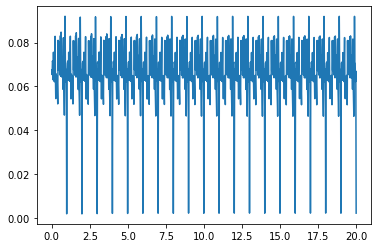

In [37]:

plt.plot(train_loss[:, 0], train_loss[:, 1])

In [39]:
for x, y in train_loader:
    print(x.size())
    print(y.size())
    break

RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0. Got 50 and 11 in dimension 2 at C:\Users\builder\AppData\Local\Temp\pip-req-build-m3brw02t\aten\src\TH/generic/THTensor.cpp:612

In [51]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters())

In [52]:
val_loss = []
train_loss = []

for epoch in tqdm(range(150)):

    with torch.set_grad_enabled(False):
        sum = 0.0
        sum_v = 0.0
        sum_a = 0.0
        sum_r2 = 0.0
        for batch, test_y in validation_loader:
            pred = net(batch[1].to(device))
            loss = criterion(pred, test_y.to(device))
            sum_v += criterion(pred[:, 0], test_y.to(device)[:, 0]).item()
            sum_a += criterion(pred[:, 1], test_y.to(device)[:, 1]).item()
            sum_r2 += r2_score(test_y, pred.cpu())
            sum += loss.item()
        val_loss.append([float(epoch), sum / len(validation_loader), sum_r2 / len(validation_loader), sum_v/len(validation_loader), sum_a / len(validation_loader)])

    i = 0
    for batch, local_labels in train_loader:
        optimizer.zero_grad()

        # prediction for training and validation set
        pred = net(batch[1].to(device))
        # computing the training and validation loss
        loss_train = criterion(pred, local_labels.to(device))
        loss_train.backward()
        optimizer.step()

        i += 1
        train_loss.append([float(epoch + i/len(train_loader)), loss_train.item()])

100%|██████████| 150/150 [06:29<00:00,  2.60s/it]


Validation RMSE: 
 Max: 	 0.25 
 Min: 	 0.21 
 Mean: 	 0.22 
 std: 	 0.01 
 
 Arousel RMSE: 
 Max: 	 0.27 
 Min: 	 0.23 
 Mean: 	 0.24 
 std: 	 0.01 
 
 Valence RMSE: 
 Max: 	 0.22 
 Min: 	 0.19 
 Mean: 	 0.20 
 std: 	 0.01 
 
 R2: 
 Max: 	 0.25 
 Min: 	 -0.09 
 Mean: 	 0.15 
 std: 	 0.05 
 
 


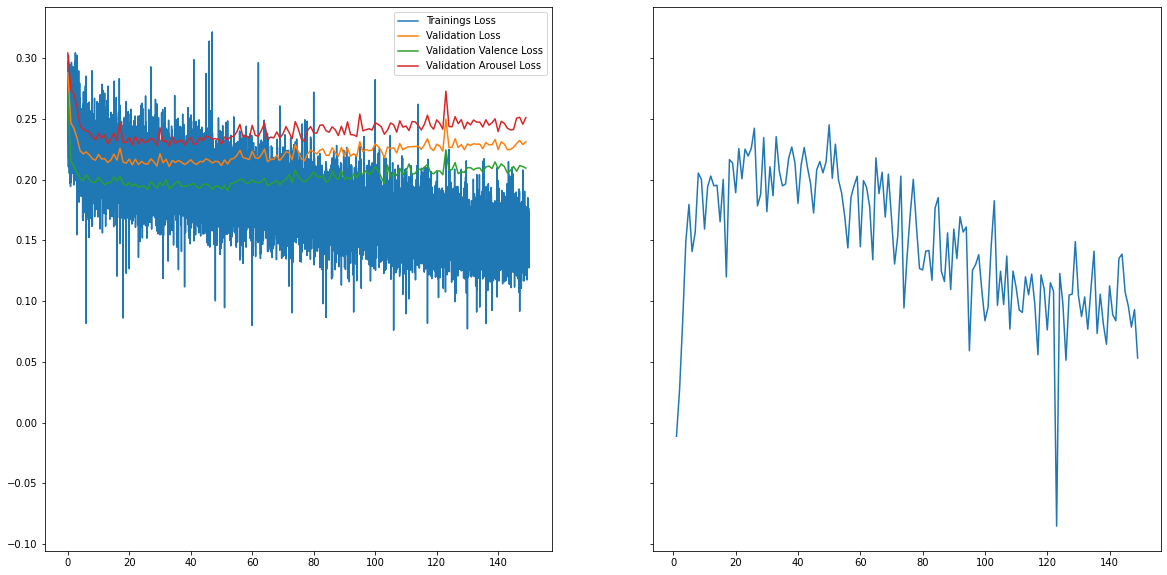

In [53]:
print_stats(val_loss, train_loss, 10)

In [28]:
def print_stats(val_loss, train_loss, start_mean_std=3):
  f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20,10))

  val_loss = np.array(val_loss)
  train_loss = np.array(train_loss)

  ax1.plot(train_loss[5:, 0], np.sqrt(train_loss[5:, 1]), label='Trainings Loss')
  ax1.plot(val_loss[:, 0], np.sqrt(val_loss[:, 1]), label='Validation Loss')
  #ax2.plot(val_loss[1:, 0], val_loss[1:, 2], label='R2 Score')
  ax1.plot(val_loss[:, 0], np.sqrt(val_loss[:, 3]), label='Validation Valence Loss')
  ax1.plot(val_loss[:, 0], np.sqrt(val_loss[:, 4]), label='Validation Arousel Loss')

  ax1.legend()

  ax2.plot(val_loss[1:, 0], val_loss[1:, 2], label='R2 Score')

  t = start_mean_std
  rmses = np.sqrt(val_loss[t:, 1])
  arousel = np.sqrt(val_loss[t:, 4])
  valences = np.sqrt(val_loss[t:, 3])
  r2 = val_loss[t:, 2]

  print(f'Validation RMSE: \n Max: \t {np.max(rmses):.2f} \n Min: \t {np.min(rmses):.2f} \n Mean: \t {np.mean(rmses):.2f} \n std: \t {np.std(rmses):.2f} \n \n ' +
        f'Arousel RMSE: \n Max: \t {np.max(arousel):.2f} \n Min: \t {np.min(arousel):.2f} \n Mean: \t {np.mean(arousel):.2f} \n std: \t {np.std(arousel):.2f} \n \n ' +
        f'Valence RMSE: \n Max: \t {np.max(valences):.2f} \n Min: \t {np.min(valences):.2f} \n Mean: \t {np.mean(valences):.2f} \n std: \t {np.std(valences):.2f} \n \n ' +
        f'R2: \n Max: \t {np.max(r2):.2f} \n Min: \t {np.min(r2):.2f} \n Mean: \t {np.mean(r2):.2f} \n std: \t {np.std(r2):.2f} \n \n ')



In [143]:
# Test:
print(dataset.file_names[20])
print(dataset.labels[40])

37.mp3
[0.1499005 0.3553182]


In [148]:
net((dataset[40][0])[None, :, :].to(device))

tensor([[0.1054, 0.1852]], device='cuda:0', grad_fn=<AddmmBackward0>)